In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df_tot = pd.read_csv("final.csv")

In [3]:
# per rispondere alle mie domande mi basta avere gli elements, quindi elimino le rige relative ai components
print("initial df.shape:",df_tot.shape)
df = df_tot.drop(df_tot[df_tot.section == "components"].index)
print("post cut df.shape:",df.shape)

initial df.shape: (214491, 19)
post cut df.shape: (136861, 19)


In [4]:
# I giudici tendono a dare voti più alti ai propri connazionali?
# per rispondere mi creo una tabella con la media dei voti che ciascun giudice ha dato
# a ciascun atleta e le nazionalità di entrambi
df.head(1)

,competition,program,performance_id,athlete_name,athlete_nation,rank,total_segment_score,total_element_score,total_component_score,total_deductions,aspect_id,aspect_desc,element_order,element_base_value,section,aspect_final_score,judge_name,judge_nation,judge_score
2,ISU European Figure Skating Championships 2017,LADIES SHORT PROGRAM,b639d77459,Evgenia MEDVEDEVA,RUS,1,78.92,42.0,36.92,0.0,38bda018f5,3Lo,4.0,5.61,elements,7.21,Agita ABELE,LAT,3.0


In [5]:
# elimino le colonne che non mi servono più
df.drop('total_segment_score', axis=1, inplace=True)
df.drop('total_component_score', axis=1, inplace=True)
df.drop('total_element_score', axis=1, inplace=True)
df.drop('section', axis=1, inplace=True)
df_q2 = df.drop('competition', axis=1)
df_q2.drop('program', axis=1, inplace=True)
df_q2.drop('performance_id', axis=1, inplace=True)
df_q2.drop('rank', axis=1, inplace=True)
df_q2.drop('total_deductions', axis=1, inplace=True)
df_q2.drop('aspect_id', axis=1, inplace=True)
df_q2.drop('aspect_desc', axis=1, inplace=True)
df_q2.drop('element_order', axis=1, inplace=True)
df_q2.drop('element_base_value', axis=1, inplace=True)
df_q2.drop('aspect_final_score', axis=1, inplace=True)
df_q2.drop('judge_name', axis=1, inplace=True)
df_q2.head(2)

,athlete_name,athlete_nation,judge_nation,judge_score
2,Evgenia MEDVEDEVA,RUS,LAT,3.0
3,Evgenia MEDVEDEVA,RUS,LAT,3.0


In [6]:
# creo una tabella che abbina a ciascun atleta il voto medio ricevuto dai giudici
# raggruppato per nazionalità dei giudici
# esempio: la media dei voti dei giudici canadesi ad Adam RIPPON è 1.5 (riga 2)
medie = df_q2.groupby(['athlete_name','athlete_nation','judge_nation'])['judge_score'].agg(['mean']).reset_index()

In [7]:
medie.head(5)

,athlete_name,athlete_nation,judge_nation,mean
0,Adam RIPPON,USA,AUS,1.1000
1,Adam RIPPON,USA,BEL,1.6500
2,Adam RIPPON,USA,CAN,1.1500
3,Adam RIPPON,USA,CHN,0.8125
4,Adam RIPPON,USA,CZE,1.2000


In [8]:
# creo la tabella atleti_voti, che alla fine sarà formata nel seguente modo:
# - athlete_name: nome dell'atleta
# - athlete_nation: nazionalità dell'atleta
# - compatriot_score: la media dei voti dati dai giudici connazionali dell'atleta
# - mean_other_nations: la media dei voti ricevuti dall'atleta, esclusi i voti dati dai connazionali
atleti_voti = pd.DataFrame(columns=['athlete_name','athlete_nation','compatriot_score'])
atleti_voti.head()

,athlete_name,athlete_nation,compatriot_score


In [9]:
# create a colum to index rows to be deleted
medie['tbd'] = False
# popolo la tabella atleti_voti con i voti dei connazionali
for ind in medie.index:
    if medie['athlete_nation'][ind] == medie['judge_nation'][ind]:
        medie.at[ind,'tbd'] = True
        atleti_voti.loc[len(atleti_voti.index)] = [medie['athlete_name'][ind],medie['athlete_nation'][ind], medie['mean'][ind]] 

In [10]:
atleti_voti.head()

,athlete_name,athlete_nation,compatriot_score
0,Adam RIPPON,USA,1.325000
1,Adele MORRISON / Demid ROKACHEV,AUS,-0.500000
2,Alaine CHARTRAND,CAN,-0.097826
3,Aleksandra BOIKOVA / Dmitrii KOZLOVSKII,RUS,0.500000
4,Alena KOSTORNAIA,RUS,2.000000


In [12]:
# per fare la media dei voti ricevuti dall'atleta, esclusi i voti dati dai connazionali,
# elimino le colonne athlete_nation e judge_nation  e elimino le righe in cui c'è il voto dei compatrioti
medie.drop('athlete_nation', axis=1, inplace=True)
medie.drop('judge_nation', axis=1, inplace=True)
medie.drop(medie[medie.tbd].index, inplace=True)
medie.drop('tbd', axis=1, inplace=True)
medie.rename(columns={'mean': 'score'}, inplace=True)

In [13]:
medie.head()

,athlete_name,score
0,Adam RIPPON,1.1000
1,Adam RIPPON,1.6500
2,Adam RIPPON,1.1500
3,Adam RIPPON,0.8125
4,Adam RIPPON,1.2000


In [14]:
medie = medie.groupby('athlete_name')['score'].agg(['mean']).reset_index()

In [15]:
medie.head()

,athlete_name,mean
0,Adam RIPPON,1.212281
1,Adel TANKOVA / Ronald ZILBERBERG,-0.577778
2,Adele MORRISON / Demid ROKACHEV,-0.625000
3,Aimee BUCHANAN,-0.412698
4,Alaine CHARTRAND,-0.190253


In [16]:
# facendo la join tra le due tabelle, popolo la colonna mean_other_nations di atleti_voti
# (vogliamo considerare solo gli atleti che sono stati giudicati da connazionali, scartiamo gli altri)
print('atleti_voti.shape: ',atleti_voti.shape)
print('medie.shape: ',medie.shape)
atleti_voti = atleti_voti.merge(medie,
                how='inner',
                on='athlete_name')
medie.rename(columns={'mean': 'mean_other_nations'}, inplace=True)
print('atleti_voti.shape after: ',atleti_voti.shape)

atleti_voti.shape:  (267, 3)
medie.shape:  (319, 2)
atleti_voti.shape after:  (267, 4)


In [17]:
atleti_voti.head()

,athlete_name,athlete_nation,compatriot_score,mean
0,Adam RIPPON,USA,1.325000,1.212281
1,Adele MORRISON / Demid ROKACHEV,AUS,-0.500000,-0.625000
2,Alaine CHARTRAND,CAN,-0.097826,-0.190253
3,Aleksandra BOIKOVA / Dmitrii KOZLOVSKII,RUS,0.500000,0.089506
4,Alena KOSTORNAIA,RUS,2.000000,1.784722


In [18]:
atleti_voti.shape

(267, 4)

In [19]:
# per poter fare il barplot devo fare quanto segue
tidy = atleti_voti.drop('athlete_nation', axis=1)
tidy = tidy.melt(id_vars='athlete_name').rename(columns=str.title)

In [20]:
# adesso i voti dati ad un atleta sono salvati in questo modo
tidy.loc[tidy['Athlete_Name'] == 'Adam RIPPON']

,Athlete_Name,Variable,Value
0,Adam RIPPON,compatriot_score,1.325000
267,Adam RIPPON,mean,1.212281


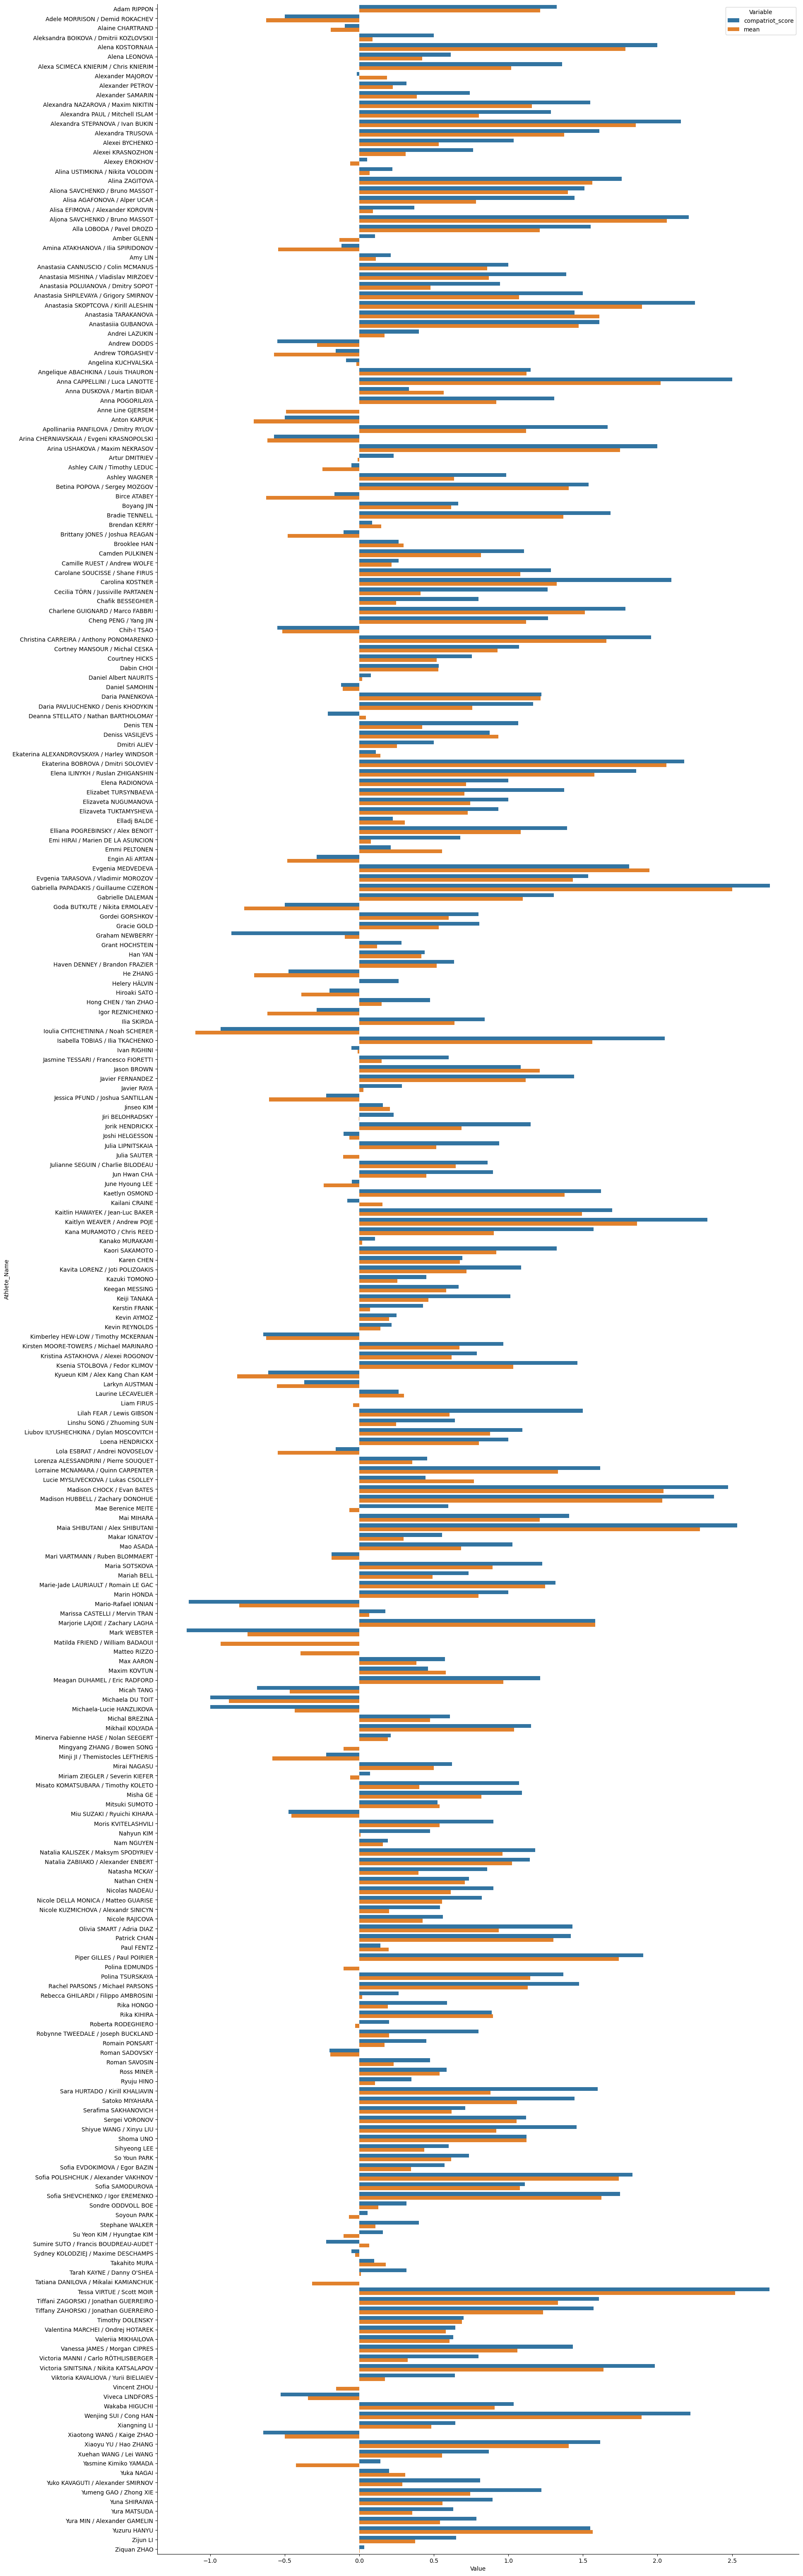

In [21]:
fig, ax1 = plt.subplots(figsize=(20, 80))
sns.barplot(y='Athlete_Name', x='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)

In [22]:
# questa visualizzazione mi piace, ma è un po' troppo grossa
# si vede che spesso la media dei voti dei connazionali è superiore alla
# media dei voti degli altri giudici

In [29]:
# voglio fare la stessa cosa ma per nazioni, invece che per atleti
# la tabella nazioni_voti sarà come segue:
# - nation: nazionalità considerata
# - compatriot_score: la media dei voti dati agli atleti di nation dai giudici connazionali
# - mean_other_nations: la media dei voti ricevuti dagli atleti di nation, esclusi i voti dati dai connazionali
nazioni_voti = pd.DataFrame(columns=['nation','compatriot_score'])
nazioni_voti.head()

,nation,compatriot_score


In [30]:
# creo una tabella che abbina a ciascun atleta il voto medio ricevuto dai giudici
# raggruppato per nazionalità dei giudici
# esempio: la media dei voti dei giudici canadesi ad Adam RIPPON è 1.5 (riga 2)
medie = df_q2.groupby(['athlete_nation','judge_nation'])['judge_score'].agg(['mean']).reset_index()

In [31]:
medie.head()

,athlete_nation,judge_nation,mean
0,ARM,AUS,0.000000
1,ARM,AUT,0.000000
2,ARM,BEL,0.000000
3,ARM,BLR,-0.205128
4,ARM,BUL,0.090909


In [32]:
# create a colum to index rows to be deleted
medie['tbd'] = False
# popolo la tabella nazioni_voti con i voti dei connazionali
for ind in medie.index:
    if medie['athlete_nation'][ind] == medie['judge_nation'][ind]:
        medie.at[ind,'tbd'] = True
        nazioni_voti.loc[len(nazioni_voti.index)] = [medie['athlete_nation'][ind], medie['mean'][ind]] 

In [33]:
medie.head()

,athlete_nation,judge_nation,mean,tbd
0,ARM,AUS,0.000000,False
1,ARM,AUT,0.000000,False
2,ARM,BEL,0.000000,False
3,ARM,BLR,-0.205128,False
4,ARM,BUL,0.090909,False


In [34]:
nazioni_voti.head()

,nation,compatriot_score
0,AUS,-0.125000
1,AUT,0.010309
2,BEL,1.118644
3,BLR,0.365854
4,CAN,1.089552


In [35]:
# per fare la media dei voti ricevuti da una nazione, esclusi i voti dati dai connazionali,
# elimino le colonne udge_nation e elimino le righe in cui c'è il voto dei compatrioti
medie.drop('judge_nation', axis=1, inplace=True)
medie.drop(medie[medie.tbd].index, inplace=True)
medie.drop('tbd', axis=1, inplace=True)
medie.rename(columns={'mean': 'score'}, inplace=True)

In [36]:
medie.head()

,athlete_nation,score
0,ARM,0.000000
1,ARM,0.000000
2,ARM,0.000000
3,ARM,-0.205128
4,ARM,0.090909


In [37]:
medie = medie.groupby('athlete_nation')['score'].agg(['mean']).reset_index()

,athlete_nation,mean
0,ARM,0.115435
1,AUS,0.045190
2,AUT,-0.122082
3,AZE,-0.382580
4,BEL,0.660148


In [43]:
medie.head(1)

,athlete_nation,mean
0,ARM,0.115435


In [44]:
nazioni_voti.head(1)

,nation,compatriot_score
0,AUS,-0.125


In [45]:
# facendo la join tra le due tabelle, popolo la colonna mean_other_nations di nazioni_voti
# (vogliamo considerare solo le nazioni che hanno ricevuto voti da giudici di quella nazione, scartiamo gli altri)
print('nazioni_voti.shape: ',nazioni_voti.shape)
print('medie.shape: ',medie.shape)
nazioni_voti = nazioni_voti.merge(medie,
                how='inner',
                left_on='nation',
                right_on = 'athlete_nation')
nazioni_voti.rename(columns={'mean': 'mean_other_nations'}, inplace=True)
print('nazioni_voti.shape after: ',nazioni_voti.shape)

nazioni_voti.shape:  (34, 2)
medie.shape:  (49, 2)
nazioni_voti.shape after:  (34, 4)


In [47]:
nazioni_voti.drop('athlete_nation', axis=1, inplace=True)
nazioni_voti.head()

,nation,compatriot_score,mean_other_nations
0,AUS,-0.125000,0.045190
1,AUT,0.010309,-0.122082
2,BEL,1.118644,0.660148
3,BLR,0.365854,-0.110833
4,CAN,1.089552,0.970309


In [50]:
# per poter fare il barplot devo fare quanto segue
tidy = nazioni_voti.melt(id_vars='nation').rename(columns=str.title)

In [51]:
tidy.head()

,Nation,Variable,Value
0,AUS,compatriot_score,-0.125000
1,AUT,compatriot_score,0.010309
2,BEL,compatriot_score,1.118644
3,BLR,compatriot_score,0.365854
4,CAN,compatriot_score,1.089552


In [52]:
# adesso i voti dati ad un atleta sono salvati in questo modo
tidy.loc[tidy['Nation'] == 'AUS']

,Nation,Variable,Value
0,AUS,compatriot_score,-0.12500
34,AUS,mean_other_nations,0.04519


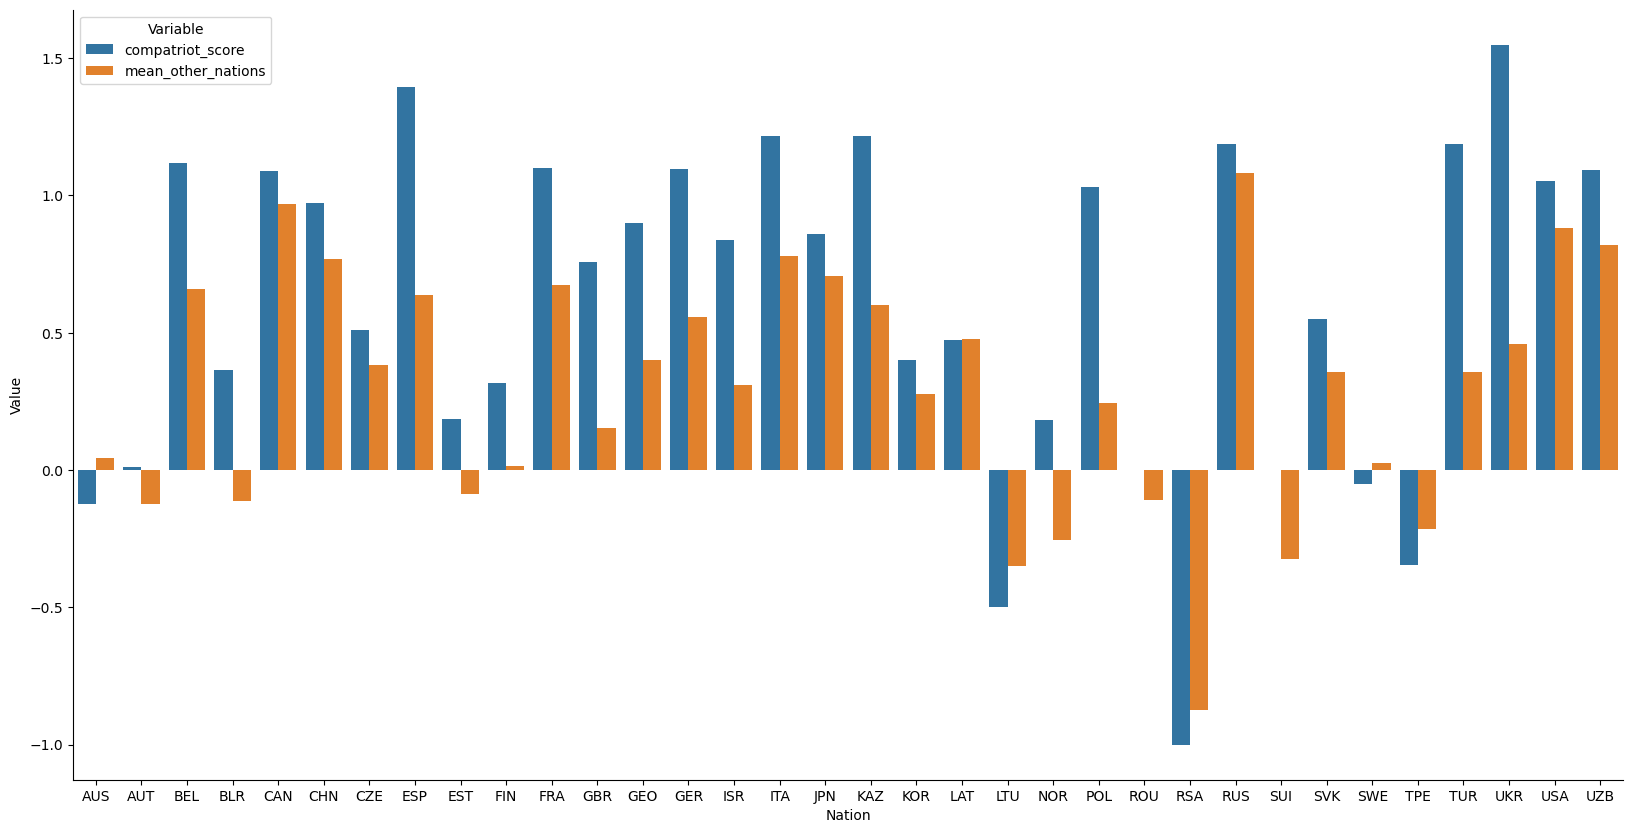

In [56]:
fig, ax1 = plt.subplots(figsize=(20, 10))
sns.barplot(x='Nation', y='Value', hue='Variable', data=tidy, ax=ax1)
sns.despine(fig)